In [1]:
import numpy as np
import nibabel as nib                                                     
#import itk                                                                
#import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
%matplotlib inline
import seaborn as sns

In [2]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2

In [3]:
#import tarfile
#file = tarfile.open('D:/Thirumalai/1138/Brain_Tumor/BraTS2021_Training_Data.tar')

#file.extractall('D:/Thirumalai/1138/Brain_Tumor/brain_images')
#file.close()

In [4]:
image_path = "D:/Thirumalai/BRAIN_U-NET/BraTS2021_00284/BraTS2021_00284_t1.nii"
image_obj = nib.load(image_path)
print(image_obj)
type(image_obj)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 240, 155)
affine: 
[[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b   

nibabel.nifti1.Nifti1Image

In [5]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

Text(0.5, 1.0, 'Mask')

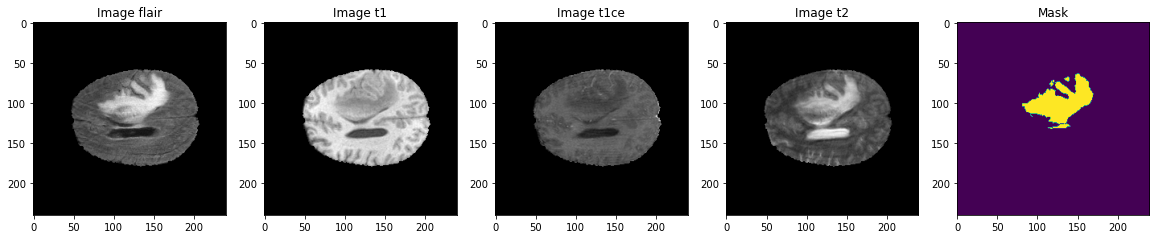

In [6]:
import os
os.chdir('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/')

TRAIN_DATASET_PATH = 'D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = 'D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

total count: 1264556


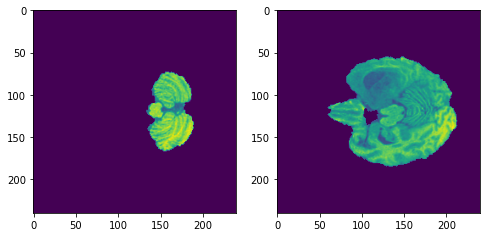

In [7]:
# returns count of non zero elements in whole 3D volume
def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

In [8]:
image_data = image_obj.get_data()
print(type(image_data))
image_data.shape

<class 'numpy.memmap'>


<ipython-input-8-746e2523e74f>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  image_data = image_obj.get_data()


(240, 240, 155)

In [9]:
# set home directory and data directory
HOME_DIR = 'D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/'
DATA_DIR = HOME_DIR

In [10]:
image_nifty_file = DATA_DIR + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii'
image = np.array(nib.load(image_nifty_file).get_fdata())

In [11]:
image.shape

(240, 240, 155)

In [12]:
label_nifty_file = DATA_DIR + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii'
label = np.array(nib.load(label_nifty_file).get_fdata())

In [13]:
label.shape

(240, 240, 155)

In [14]:
from tensorflow.keras.utils import to_categorical
is_categorical=False
if not is_categorical:
    label_cat = to_categorical(label, num_classes=0).astype(np.uint8)
label_cat.shape

(240, 240, 155, 5)

In [15]:
image_norm = cv2.normalize(image[:, :, :], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
image_norm.shape

(240, 240, 155)

In [16]:
labeled_image = np.zeros_like(label_cat[:, :, :, 1:])

# remove tumor part from image
labeled_image[:, :, :, 0] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 1] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 2] = image_norm * (label_cat[:, :, :, 0])

# color labels
labeled_image += label_cat[:, :, :, 1:] * 255

labeled_image.shape

(240, 240, 155, 4)

In [17]:
data_all = []
data_all.append(labeled_image)
np.array(data_all).shape

(1, 240, 240, 155, 4)

In [18]:
# coronal plane
coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
coronal = np.rot90(coronal, 1)
coronal.shape

(155, 240, 240, 4, 1)

In [19]:
# transversal plane
transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
transversal = np.rot90(transversal, 2)
transversal.shape

(240, 240, 155, 4, 1)

In [20]:
# sagittal plane
sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
sagittal = np.rot90(sagittal, 1)
sagittal.shape

(155, 240, 240, 4, 1)

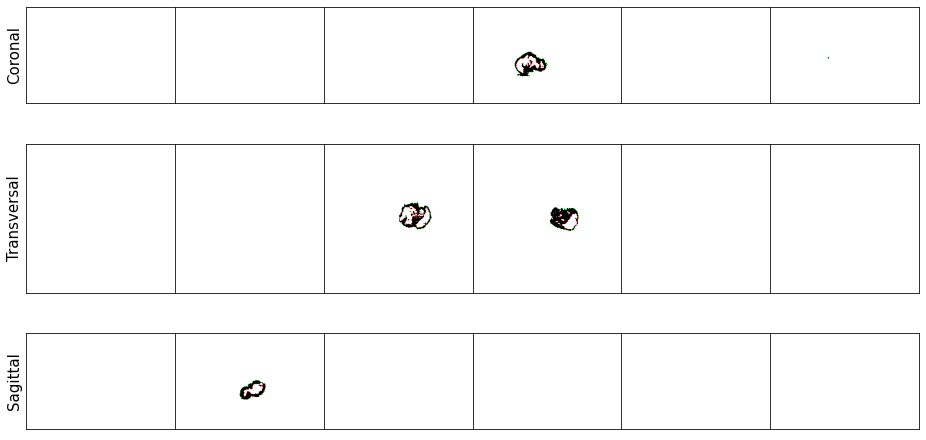

In [21]:
fig, ax = plt.subplots(3, 6, figsize=[16, 9])

for i in range(6):
    n = np.random.randint(coronal.shape[2])
    ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('Coronal', fontsize=15)

for i in range(6):
    n = np.random.randint(transversal.shape[2])
    ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[1][i].set_ylabel('Transversal', fontsize=15)

for i in range(6):
    n = np.random.randint(sagittal.shape[2])
    ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])
    if i == 0:
        ax[2][i].set_ylabel('Sagittal', fontsize=15)

fig.subplots_adjust(wspace=0, hspace=0)

In [22]:
import imageio
def visualize_data_gif(data_):
    images = []
    for i in range(data_.shape[0]):
        x = data_[min(i, data_.shape[0] - 1), :, :]
        y = data_[:, min(i, data_.shape[1] - 1), :]
        z = data_[:, :, min(i, data_.shape[2] - 1)]
        img = np.concatenate((x, y, z), axis=1)
        images.append(img)
    imageio.mimsave("D:/Thirumalai/BRAIN_U-NET/gif.gif", images, duration=0.01)
    #return image(filename="./gif.gif", format='png')

In [23]:
visualize_data_gif(labeled_image)

In [24]:
import numpy as np
def visualize_3d(layer):
   # np.asarray(image_data).astype('float32') 
    plt.figure(figsize=(8, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray');
    plt.axis('off')
    return layer

interact(visualize_3d, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [25]:
layer = 50
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3. 
}

def visualize_3d_labels(layer):
    mask = nib.load("D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii").get_data()
    plt.imshow(mask[:,:,layer])
    plt.axis('off')
    plt.tight_layout()

interact(visualize_3d_labels, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

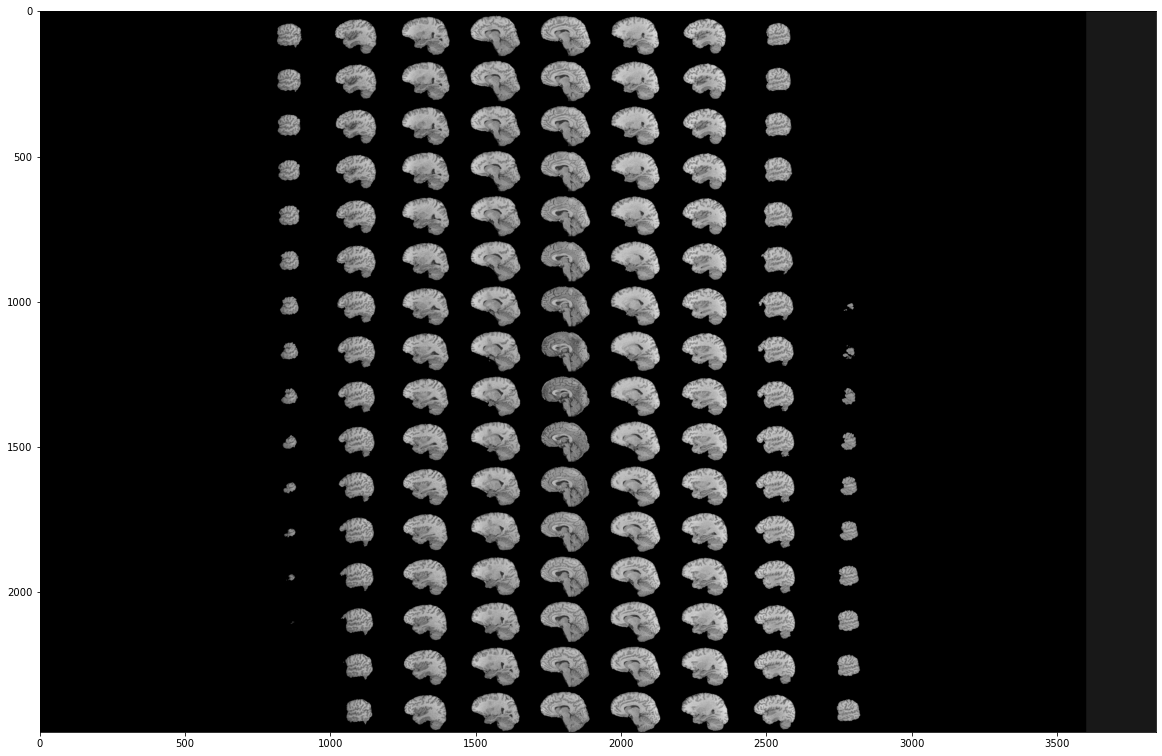

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(image_data[:,:,:]), 90, resize=True), cmap ='gray')

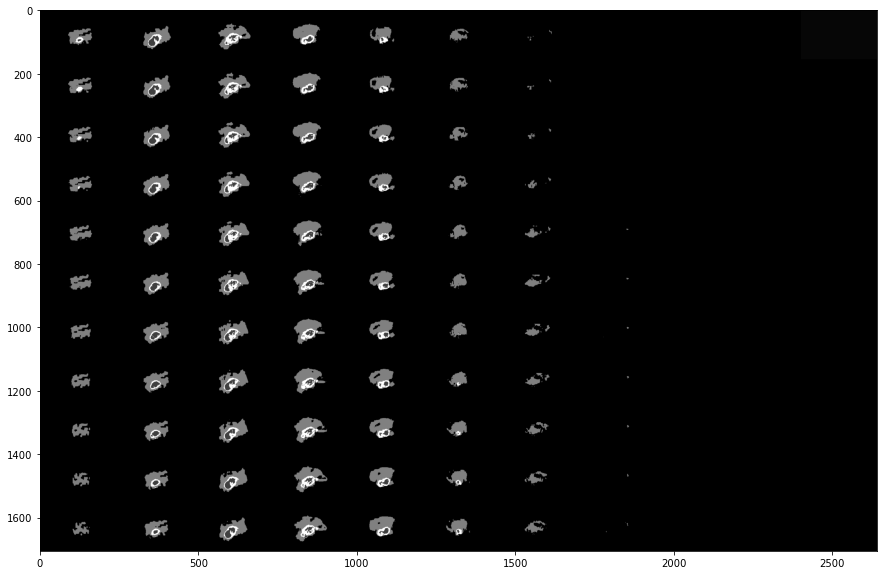

In [27]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

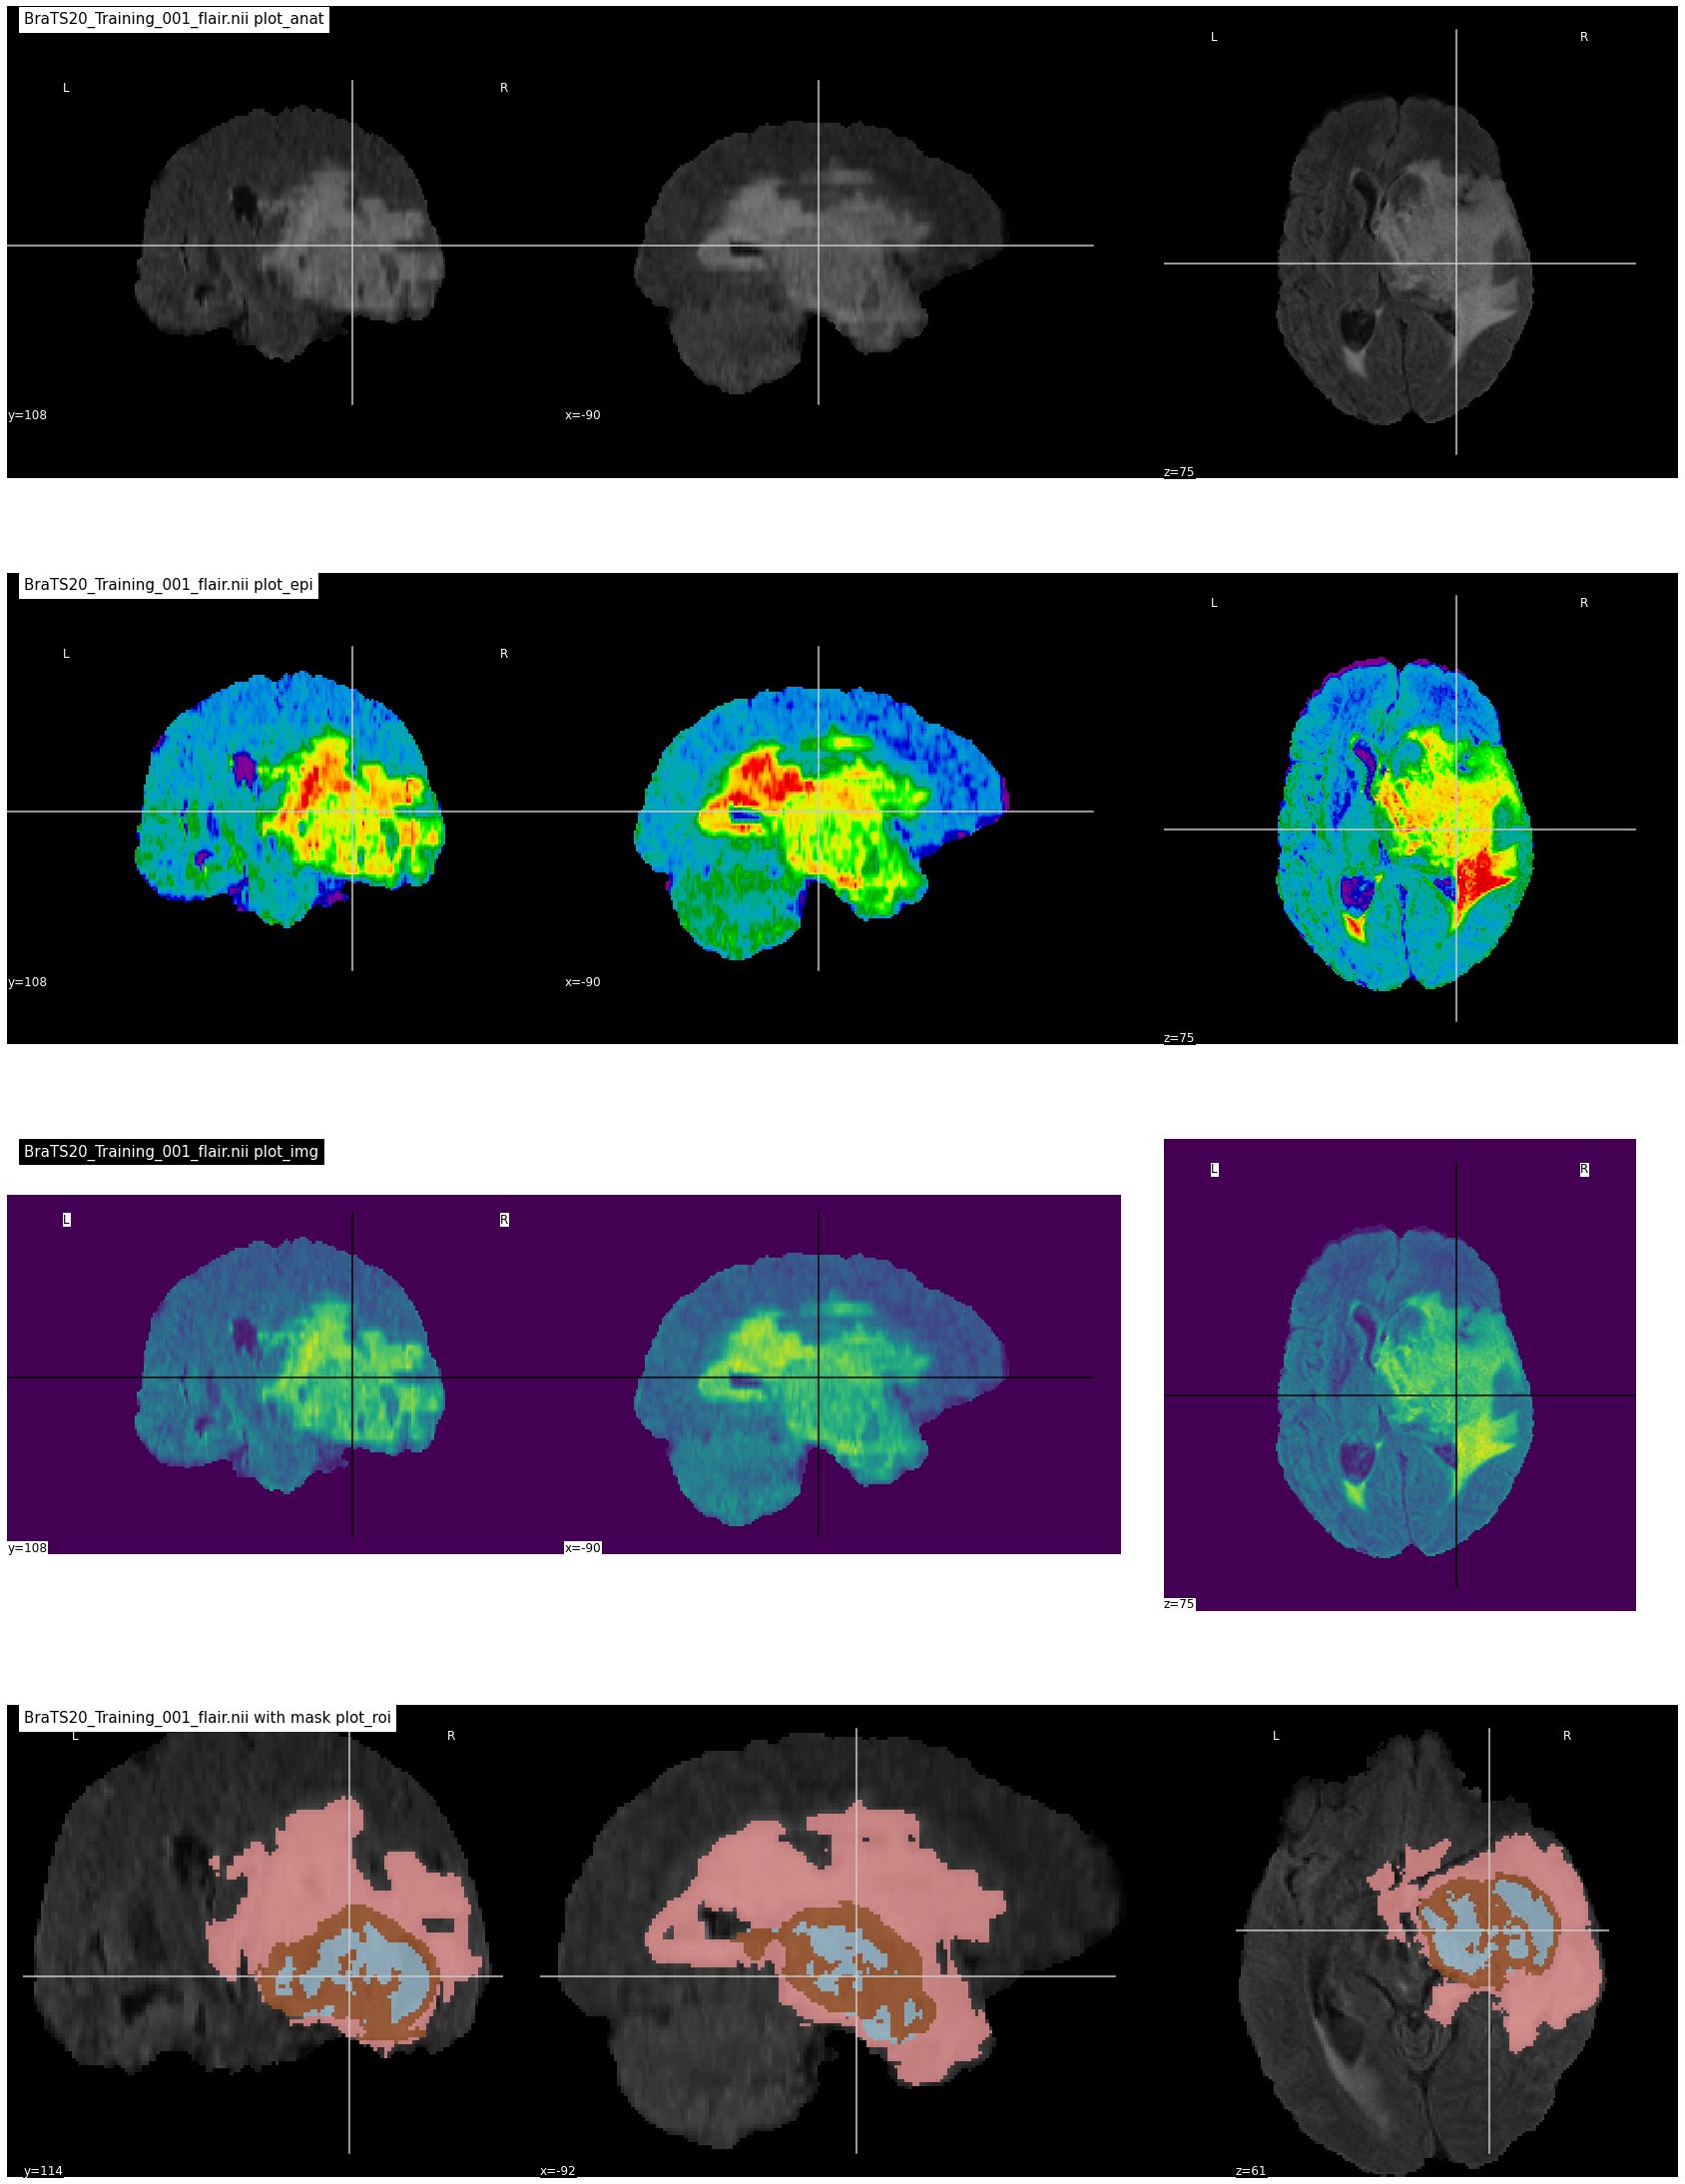

In [28]:
niimg = nl.image.load_img('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [29]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [30]:
IMG_SIZE=128

In [31]:
import tarfile
TRAIN_DATASET_PATH = 'D:/Thirumalai/BRAIN_U-NET/BraTS2021_00621.1/ZIPFILE/'
print(TRAIN_DATASET_PATH)
file = tarfile.open('D:/Thirumalai/BRAIN_U-NET/BraTS2021_00621.1/ZIPFILE/BraTS2021_00621.tar')
file.extractall('D:/Thirumalai/BRAIN_U-NET/BraTS2021_00621.1/ZIPFILE/val_brain_images')
file.close()

D:/Thirumalai/BRAIN_U-NET/BraTS2021_00621.1/ZIPFILE/


In [32]:
VALIDATION_DATASET_PATH = 'D:/Thirumalai/BRAIN_U-NET/BraTS2021_00621.1/ZIPFILE/val_brain_images'

In [33]:
import os
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [34]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData') if f.is_dir()]
#print(train_and_val_directories)
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [35]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 128 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [36]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
             X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
             
             
             y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        X = X.reshape(1,128,128,128,2)
        y = y.reshape(1,128,128,128)
        # Generate masks
        y[y==4] = 3;
        y = tf.one_hot(y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        #Y = np.array(Y).reshape(1,128,128,128)
        return X/np.max(X), y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [37]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),
      csv_logger
    ]

In [38]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
    
  X = add([input_mat,X]);
  
  return X


def Vnet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

  #c1 = conv_block(input_img,n_filters,3,batch_norm)
  c1 = Conv3D(n_filters,kernel_size = (5,5,5) , strides = (1,1,1) , padding='same')(input_img)
  #c1 = add([c1,input_img])
  
  c2 = Conv3D(n_filters*2,kernel_size = (2,2,2) , strides = (2,2,2) , padding = 'same' )(c1)
  
  c3 = conv_block(c2 , n_filters*2,5,True)
  
  p3 = Conv3D(n_filters*4,kernel_size = (2,2,2) , strides = (2,2,2), padding = 'same')(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3, n_filters*4,5,True)
  p4 = Conv3D(n_filters*8,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c4)
  p4 = Dropout(dropout)(p4)
    
  c5 = conv_block(p4, n_filters*8,5,True)
  p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c5)
  p6 = Dropout(dropout)(p6)
  #c6 = conv_block(p5, n_filters*8,5,True)
  #p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c6)

  p7 = conv_block(p6,n_filters*16,5,True)
    
  u6 = Conv3DTranspose(n_filters*8, (2,2,2), strides=(2, 2, 2), padding='same')(p7);
  u6 = concatenate([u6,c5]);
  c7 = conv_block(u6,n_filters*16,5,True)
  c7 = Dropout(dropout)(c7)
  u7 = Conv3DTranspose(n_filters*4,(2,2,2),strides = (2,2,2) , padding= 'same')(c7);

  
  u8 = concatenate([u7,c4]);
  c8 = conv_block(u8,n_filters*8,5,True)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters*2,(2,2,2),strides = (2,2,2) , padding= 'same')(c8);
    
  u9 = concatenate([u9,c3]);
  c9 = conv_block(u9,n_filters*4,5,True)
  c9 = Dropout(dropout)(c9)
  u10 = Conv3DTranspose(n_filters,(2,2,2),strides = (2,2,2) , padding= 'same')(c9);
  
  
  u10 = concatenate([u10,c1]);
  c10 = Conv3D(n_filters*2,kernel_size = (5,5,5),strides = (1,1,1) , padding = 'same')(u10);
  c10 = Dropout(dropout)(c10)
  c10 = add([c10,u10]);
  
  

  #c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1,1,1), activation='softmax')(c10)

  model = Model(inputs=input_img, outputs=outputs)

  return model

In [47]:
input_layer = Input((128,IMG_SIZE, IMG_SIZE, 2))

model1 = Vnet_3d(input_layer)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                            dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, 
                                                                                                                dice_coef_edema ,dice_coef_enhancing] )

model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 2)]                                                           
                                                                                                  
 conv3d_42 (Conv3D)             (None, 128, 128, 12  2008        ['input_3[0][0]']                
                                8, 8)                                                             
                                                                                                  
 conv3d_43 (Conv3D)             (None, 64, 64, 64,   1040        ['conv3d_42[0][0]']              
                                16)                                                         

                                                                                                  
 add_18 (Add)                   (None, 16, 16, 16,   0           ['dropout_15[0][0]',             
                                64)                               'activation_33[0][0]']          
                                                                                                  
 conv3d_52 (Conv3D)             (None, 8, 8, 8, 128  65664       ['add_18[0][0]']                 
                                )                                                                 
                                                                                                  
 dropout_16 (Dropout)           (None, 8, 8, 8, 128  0           ['conv3d_52[0][0]']              
                                )                                                                 
                                                                                                  
 conv3d_53

                                64)                                                               
                                                                                                  
 add_21 (Add)                   (None, 32, 32, 32,   0           ['concatenate_9[0][0]',          
                                64)                               'activation_39[0][0]']          
                                                                                                  
 dropout_18 (Dropout)           (None, 32, 32, 32,   0           ['add_21[0][0]']                 
                                64)                                                               
                                                                                                  
 conv3d_transpose_10 (Conv3DTra  (None, 64, 64, 64,   8208       ['dropout_18[0][0]']             
 nspose)                        16)                                                               
          

In [40]:
plot_model(model1, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


No handles with labels found to put in legend.


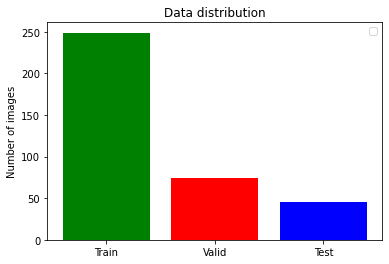

In [41]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

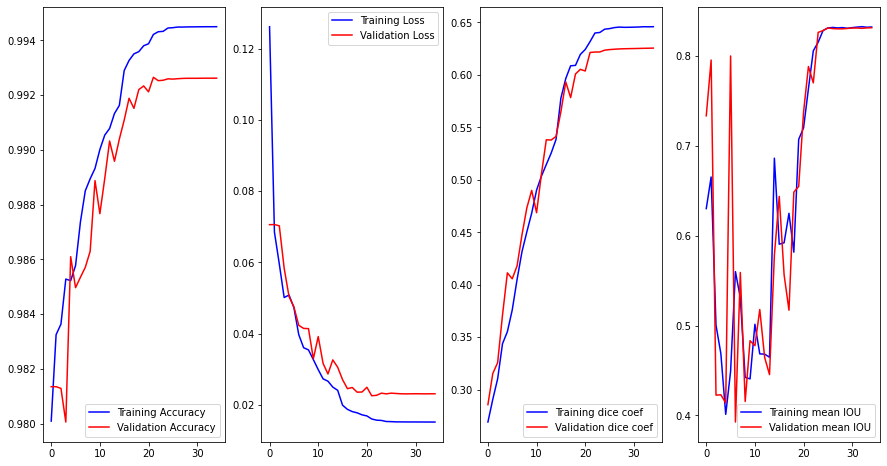

In [53]:
import pandas as pd
model1 = tf.keras.models.load_model('D:/Thirumalai/BRAIN_U-NET/model-per-class-eval/model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('D:/Thirumalai/BRAIN_U-NET/model-per-class-eval/training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(15,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [62]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

4/4 [==============================] - 8s 2s/step


<Figure size 1296x3600 with 0 Axes>

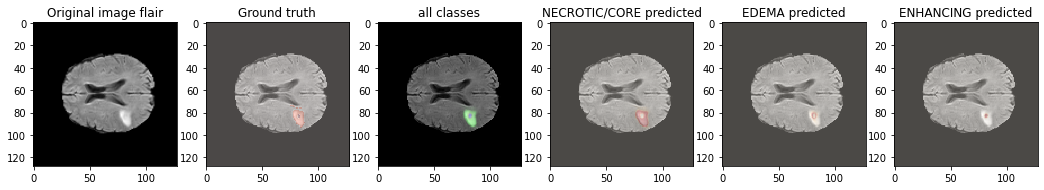

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

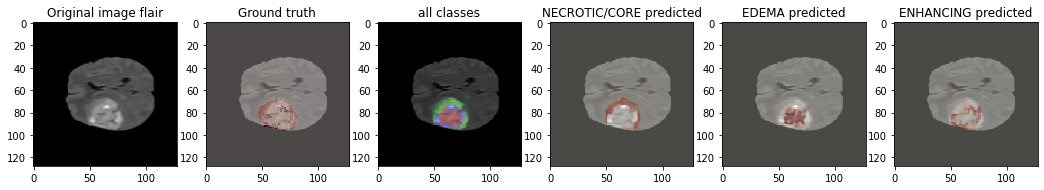

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

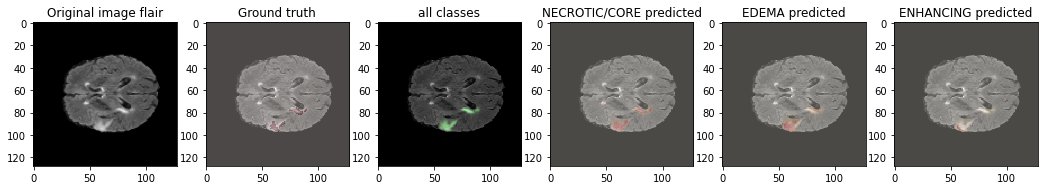

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

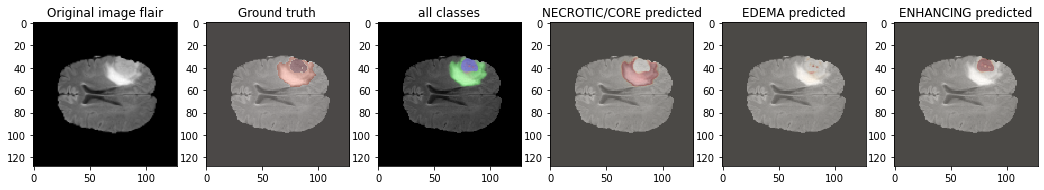

4/4 [==============================] - 8s 2s/step


<Figure size 1296x3600 with 0 Axes>

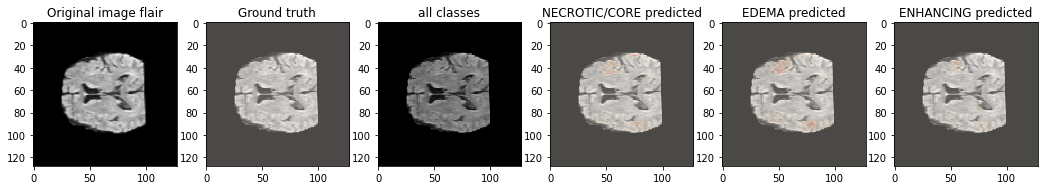

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

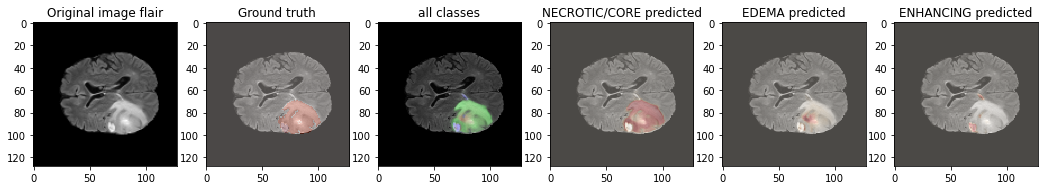

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

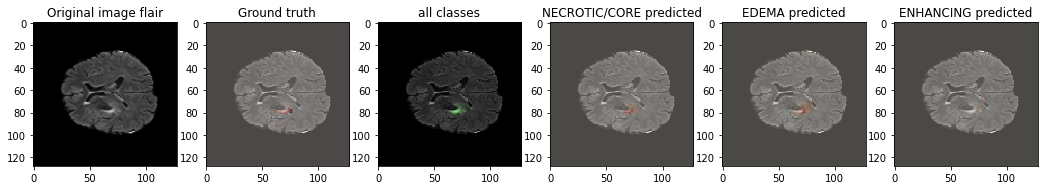

In [55]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model1.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

4/4 [==============================] - 7s 2s/step


<Figure size 432x288 with 0 Axes>

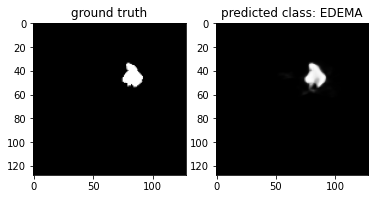

In [56]:
case = case=test_ids[3][-3:]
path = f"D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [59]:
model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate(val_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


NameError: name 'val_generator' is not defined

In [ ]:
import tensorflow as tf
from tensorflow import keras
def build_unet(inputs, ker_init, dropout):
    print(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
#model.compile(optimizer= tensorflow.keras.optimizers.adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='categorical_crossentropy', metrics = ['accuracy']) 
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [ ]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData') if f.is_dir()]
#print(train_and_val_directories)
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove('D:/Thirumalai/BRAIN_U-NET/BraTS2020Dataset/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 
#print(train_ids, test_ids)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)
print(test_generator)

In [ ]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'blue','yellow', 'pink'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [ ]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [ ]:
############ load trained model ################
model = keras.models.load_model('D:/Thirumalai/BRAIN_U-NET/model-per-class-eval/model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('D:/Thirumalai/BRAIN_U-NET/model-per-class-eval/training_per_class.log', sep=',', engine='python')

hist=history
print(hist)

In [ ]:
#print(test_ids) 
#test_generator = test_ids

import sys
import os
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
#model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
#print(test_generator)
results = model.predict(test_generator, batch_size=64, callbacks= callbacks)
print("test loss, test acc:", results)